## DSC 180AB Data Science Capstone
### Replication Project

Team Members:

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

We care about this because it is in our best possible interest to investigate how different groups of people interact with the healthcare system depending on several features whether that is race, sex, marital status, etc. By understanding how these different factors relate to whether certain people interact with the health care system we can improve and better our current systems. Whether that would be creating more efficient systems, allocating resources differently, and lastly uncovering any inequalities in our system so that everyone receives fair treatment. While the use of AI can help us accelerate the improvement of these systems we also make sure that our use of AI is fair and unbiased. This is why we not only have to strive for high accuracy but also for low bias and disparity when it comes to prediction results. Ensuring our models are not only accurate but also fair then it will allow us to greatly improve our healthcare systems to better treat underrepresented populations. There are several benefits to predicting utilization. For example, it can help us understand how to better allocate resources by understanding which groups require the most medical care. We can shift resources to those groups rather than to groups who may not necessarily need as much care. Another example is it would allow our healthcare system to be more proactive in that by knowing which groups may need more care we can implement systems that can intervene early thus reducing further medical issues and cost. Lastly, it can reduce medical costs since utilization can help manage groups of people that may need more medical care than others by providing more specific care effectively.

If there are errors in trying to predict whether or not a patient is labeled as high utilization, the physical and financial wellbeing of the patient are being put at risk. If the model is found to be biased or falsely labeling patients as high utilization, these individuals are likely to experience unnecessary treatments. On the contrary, if the the model is failing to identify high-utilization patients, these indiviudals could be put at risk, possibly even as severe as life or death. Regardless, in both of these outcomes, an error-prone model will likely have its nature questioned and the stakeholders who interact with it will be hesitant to utilize it. Not only can this potentially ruin the reputation of the engineers who designed the model, but if this information goes public, so will the reputation of the hospital be at stake.

The affected parties in this scenario include patients, care management staff, and healthcare providers. Patients could either be unfairly prioritized or overlooked based on biased predictions, which could lead to unequal access to life-saving care. Healthcare providers and care managers may also rely on these models to make informed decisions about care management, and if the model is biased, it could lead to suboptimal care allocation and affect their overall efficiency. Finally, stakeholders such as hospital administrators, insurers, and policymakers have a vested interest in ensuring that healthcare systems run fairly and efficiently, in line with legal and ethical standards.

**Write up here:**

---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [1]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline



import requests
from bs4 import BeautifulSoup

import re

pd.set_option('display.max_columns', None)

/Users/ethanslin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
raw_181 = pd.read_csv('aif360/data/raw/meps/h181.csv')

#### Apply pre-processing scripts

In [3]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [4]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [5]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [6]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [7]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

#### 2.2 Data shape and features

In [8]:


renamed_cols = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'}


reverse_renaming = dict(zip(renamed_cols.values(), renamed_cols.keys()))
def parse_codebook_table_by_column(col):
    ### some columns have been renamed (MARRY53X -> MARRY)
    if col in reverse_renaming:
        col = reverse_renaming[col]
    
    url = f'https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H181&varName={col}'

    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        table = soup.find_all('table', {'summary': 'table navigation'})[1]

        table_data = []

        rows = table.find_all('tr')
        for row in rows:
            cols = row.find_all('td') 
            cols = [col.get_text(strip=True).replace(',', '') for col in cols]  
            if len(cols) > 0: 
                table_data.append(cols)

        try:
            df = pd.DataFrame(table_data, columns=["VALUE", "UNWEIGHTED", "WEIGHTED BY PERWT15F"])

            # get rid of duplicate table header
            df = df[df['VALUE'] != 'VALUE']

            #drop total row if it exists
            df = df[df['VALUE'] != 'TOTAL']

            df[['VALUE', 'VALUE_MAPPED']] = df['VALUE'].str.extract(r'(^[\d.\- ]+)(.*)', expand=True)
            df['VALUE'] = df['VALUE'].str.strip()
            df['VALUE_MAPPED'] = df['VALUE_MAPPED'].str.strip()

            mapper = dict(zip(df['VALUE'], df['VALUE_MAPPED']))
        except Exception:
            print(f'Failed to locate mapper for: {col}')
            mapper = {}
    else:
        # for the columns that fail, return an empty dict
        mapper = {}
        
    return mapper

In [9]:
for col in df_panel_19_reduced:
   df_panel_19_reduced[col].map(parse_codebook_table_by_column(col))

Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


In [10]:
for col in df_panel_20_reduced:
   df_panel_20_reduced[col].map(parse_codebook_table_by_column(col))

Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


In [11]:
regions = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
sex = {1: 'MALE', 2:'FEMALE'}
marry = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'MARRIED', 2: 'WIDOWED', 3: 'DIVORCED', 4: 'SEPARATED', 5: 'NEVER MARRIED', 6: 'UNDER 16 - INAPPLICABLE', 7: 'MARRIED IN ROUND', 8: 'WIDOWED IN ROUND', 9: 'DIVORCED IN ROUND', 10: 'SEPARATED IN ROUND'}
ftstu = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE', 1: 'FULL-TIME', 2: 'PART-TIME', 3: 'NOT A STUDENT'}
actdty = {-9: 'NOT ASCERTAINED', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO', 3: 'UNDER 16 - INAPPLICABLE', 4: 'OVER 59 - INAPPLICABLE'}
honrdc = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO', 3: 'UNDER 16 - INAPPLICABLE', 4: 'ACTIVE DUTY'}
rthlth = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EXCELLENT', 2: 'VERY GOOD', 3: 'GOOD', 4: 'FAIR', 5: 'POOR'}
mnhlth = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EXCELLENT', 2: 'VERY GOOD', 3: 'GOOD', 4: 'FAIR', 5: 'POOR'}
hibpdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
chddx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
angidx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
midx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
ohrtdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
strkdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
emphdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
chbron = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
choldx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
cancerdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
diabdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
jtpain = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
arthdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
arthtype = {-7: 'REFUSED', -1: ' INAPPLICABLE', 1: 'RHEUMATOID ARTHRITIS',2: ' OSTEOARTHRITIS', 3: ' NOT SPECIFIED '}
asthdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
adhdaddx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
pregnt = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
wlklim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
actlim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
soclim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
coglim = {8: 'DK', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
dfhear42 = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
dfsee42 = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
adsmok42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
pcs42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
mcs42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
k6sum42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
phq242 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
empst = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EMPLOYED AT RD INT DATE', 2: 'JOB TO RETURN TO AT RD INT DATE', 3: ' JOB DURING RD REF PERIOD', 4: 'NOT EMPLOYED DURING RD'}
povcat = {1: 'POOR/NEGATIVE', 2: 'NEAR POOR', 3: 'LOW INCOME', 4: 'MIDDLE INCOME', 5: 'HIGH INCOME'}
inscov = {1: 'ANY PRIVATE', 2: 'PUBLIC ONLY', 3: 'UNINSURED'}

valueMappings = {'REGION': regions, 'SEX': sex, 'MARRY': marry, 'FTSTU': ftstu, 'ACTDTY': actdty, 'HONRDC': honrdc,
       'RTHLTH': rthlth, 'MNHLTH': mnhlth, 'HIBPDX': hibpdx, 'CHDDX': chddx, 'ANGIDX': angidx, 'MIDX': midx, 'OHRTDX': ohrtdx,
       'STRKDX': strkdx, 'EMPHDX': emphdx, 'CHBRON': chbron, 'CHOLDX': choldx, 'CANCERDX': cancerdx, 'DIABDX': diabdx, 'JTPAIN': jtpain,
       'ARTHDX': arthdx, 'ARTHTYPE': arthdx, 'ASTHDX': asthdx, 'ADHDADDX': adhdaddx, 'PREGNT': pregnt, 'WLKLIM': wlklim,
       'ACTLIM': actlim, 'SOCLIM': soclim, 'COGLIM': coglim, 'DFHEAR42': dfhear42, 'DFSEE42': dfsee42, 'ADSMOK42': adsmok42,
       'PCS42': pcs42, 'MCS42': mcs42, 'K6SUM42': k6sum42, 'PHQ242': phq242, 'EMPST': empst, 'POVCAT': povcat, 'INSCOV': inscov}

In [12]:
for variable in valueMappings:
    df_panel_19_reduced[variable] = df_panel_19_reduced[variable].replace(valueMappings[variable])
    df_panel_20_reduced[variable] = df_panel_20_reduced[variable].replace(valueMappings[variable])

/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/2586674155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_19_reduced[variable] = df_panel_19_reduced[variable].replace(valueMappings[variable])
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/2586674155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_20_reduced[variable] = df_panel_20_reduced[variable].replace(valueMappings[variable])


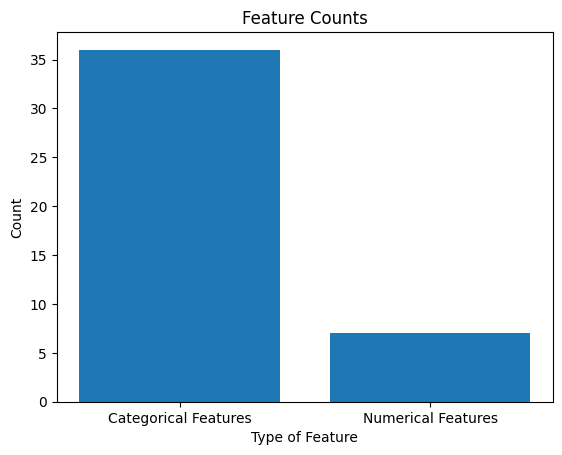

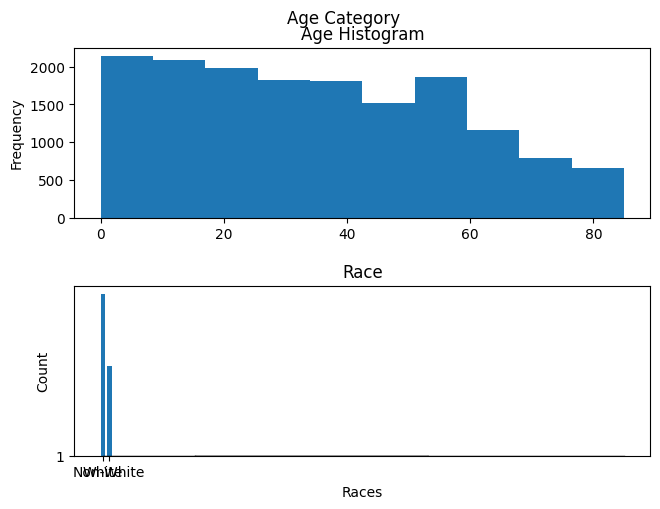

/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:50: UserWarning: set_ticklabels() should only be 

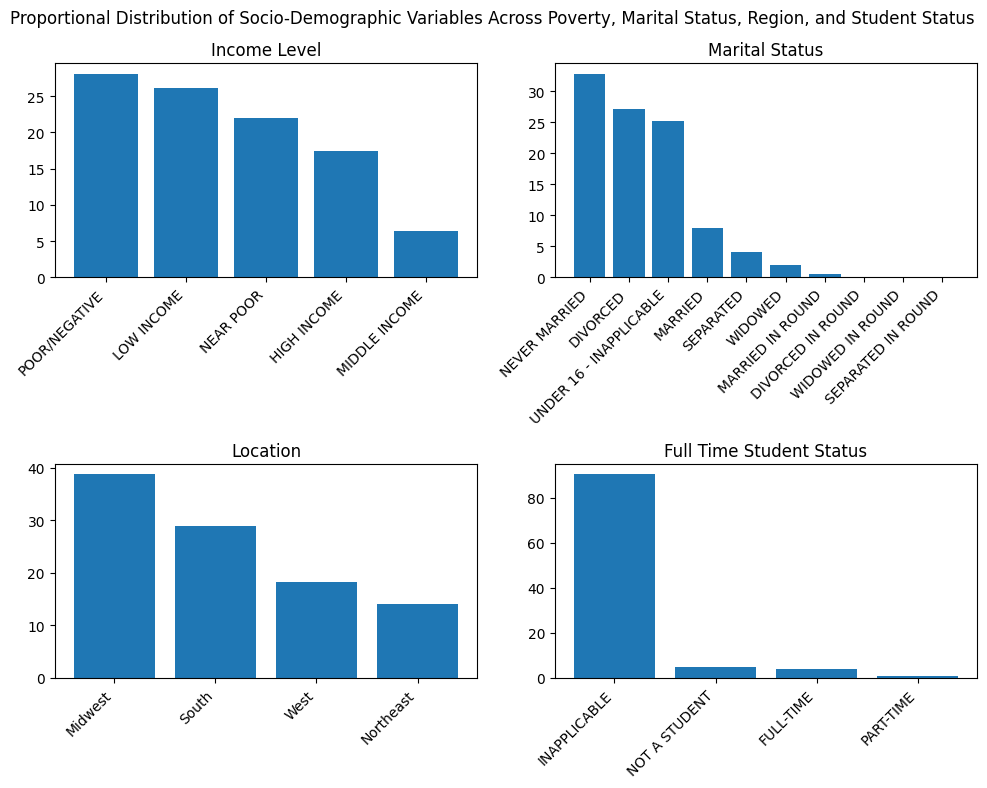

/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/930351744.py:75: UserWarning: set_ticklabels() should only be 

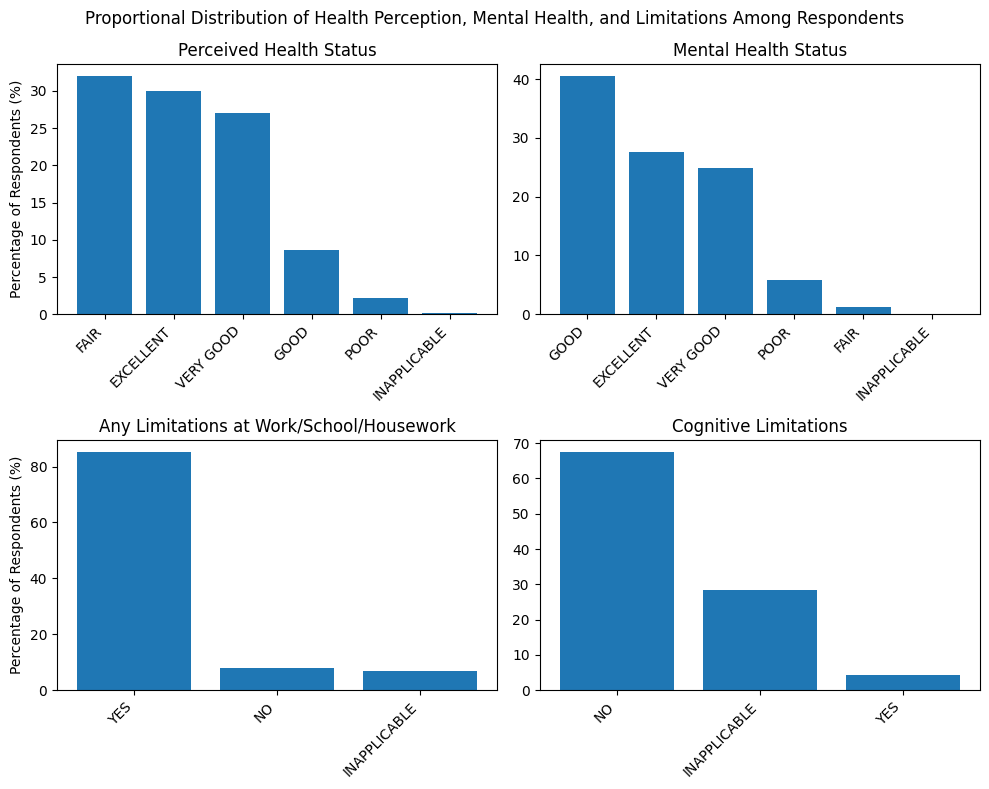

In [13]:
categorical_features = ['REGION', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'EMPST', 'POVCAT', 'INSCOV']

numerical_features = ['AGE', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'UTILIZATION', 'PERWT15F']
x = np.array(['Categorical Features', 'Numerical Features'])
y = np.array([len(categorical_features), len(numerical_features)])
plt.bar(x, y)
plt.title('Feature Counts')
plt.xlabel('Type of Feature')
plt.ylabel('Count')
plt.show()

fig, axs = plt.subplots(2)
fig.suptitle('Age Category')
axs[0].hist(df_panel_19['AGE'])
axs[1].boxplot(df_panel_19['AGE'], 0, 'rs', 0)
axs[1].set_title('Age Box Plot')
axs[0].set_title('Age Histogram')
axs[0].set(ylabel='Frequency')
axs[1].set(xlabel='Age')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)

x = df_panel_19_reduced['RACE'].unique()
y = df_panel_19_reduced['RACE'].value_counts().values
plt.bar(x, y)
plt.title('Race')
plt.xlabel('Races')
plt.ylabel('Count')
plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Socio-Demographic Variables Across Poverty, Marital Status, Region, and Student Status')

axs[0, 0].bar(df_panel_19_reduced['POVCAT'].unique(), (df_panel_19_reduced['POVCAT'].value_counts(normalize=True).values) * 100)
axs[0, 1].bar(df_panel_19_reduced['MARRY'].unique(), (df_panel_19_reduced['MARRY'].value_counts(normalize=True).values) * 100)
axs[1, 0].bar(df_panel_19_reduced['REGION'].unique(), (df_panel_19_reduced['REGION'].value_counts(normalize=True).values) * 100)
axs[1, 1].bar(df_panel_19_reduced['FTSTU'].unique(), (df_panel_19_reduced['FTSTU'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Income Level')
axs[0, 1].set_title('Marital Status')
axs[1, 0].set_title('Location')
axs[1, 1].set_title('Full Time Student Status')

for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Health Perception, Mental Health, and Limitations Among Respondents')

axs[0,0].bar(df_panel_19_reduced['RTHLTH'].unique(), (df_panel_19_reduced['RTHLTH'].value_counts(normalize=True).values) * 100)
axs[0,1].bar(df_panel_19_reduced['MNHLTH'].unique(), (df_panel_19_reduced['MNHLTH'].value_counts(normalize=True).values) * 100)
axs[1,0].bar(df_panel_19_reduced['ACTLIM'].unique(), (df_panel_19_reduced['ACTLIM'].value_counts(normalize=True).values) * 100)
axs[1,1].bar(df_panel_19_reduced['COGLIM'].unique(), (df_panel_19_reduced['COGLIM'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Perceived Health Status')
axs[0, 1].set_title('Mental Health Status')
axs[1, 0].set_title('Any Limitations at Work/School/Housework')
axs[1, 1].set_title('Cognitive Limitations')
axs[0, 0].set_ylabel('Percentage of Respondents (%)') 
axs[1, 0].set_ylabel('Percentage of Respondents (%)') 


for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()

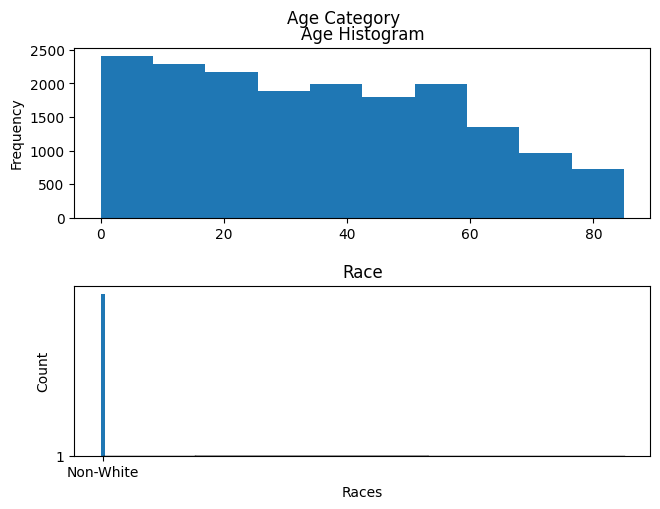

/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:35: UserWarning: set_ticklabels() should only be 

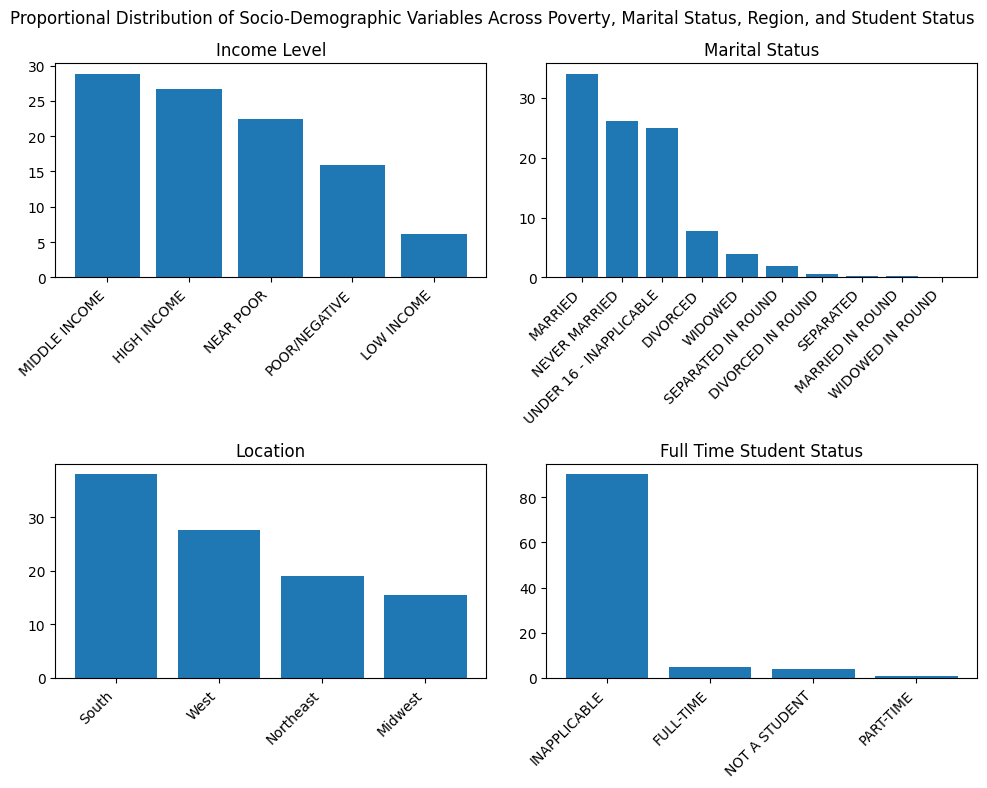

/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/432043684.py:60: UserWarning: set_ticklabels() should only be 

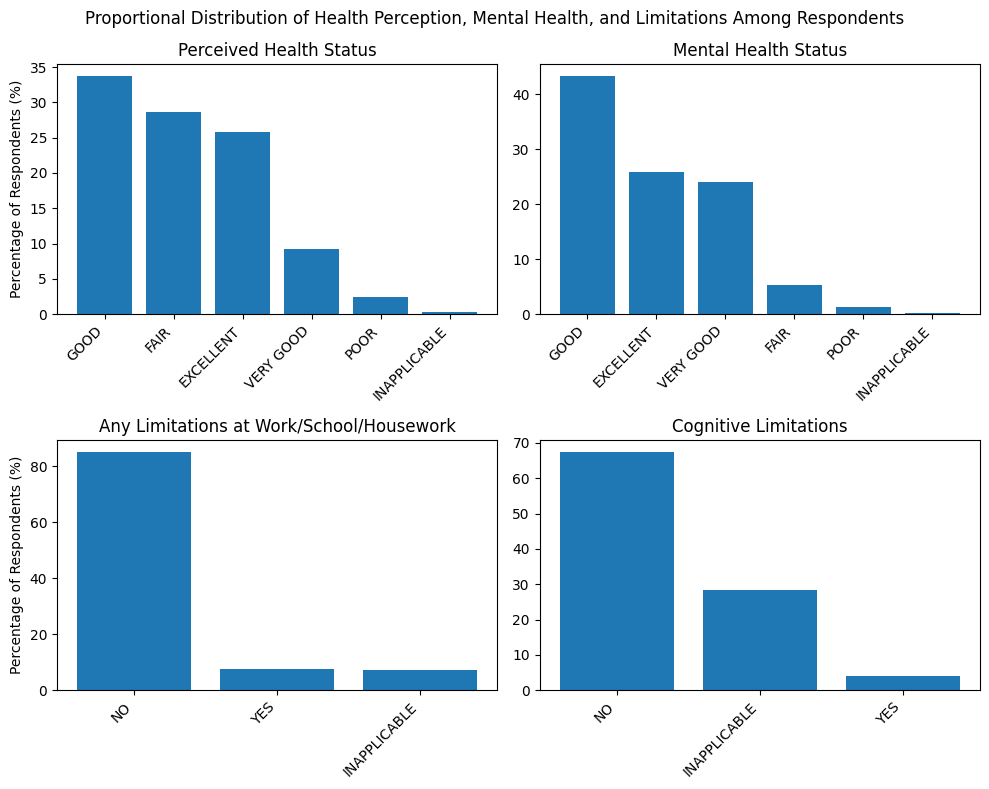

In [14]:
fig, axs = plt.subplots(2)
fig.suptitle('Age Category')
axs[0].hist(df_panel_20['AGE'])
axs[1].boxplot(df_panel_20['AGE'], 0, 'rs', 0)
axs[1].set_title('Age Box Plot')
axs[0].set_title('Age Histogram')
axs[0].set(ylabel='Frequency')
axs[1].set(xlabel='Age')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9, hspace=0.4, wspace=0.3)

x = df_panel_20_reduced['RACE'].unique()
y = df_panel_20_reduced['RACE'].value_counts().values
plt.bar(x, y)
plt.title('Race')
plt.xlabel('Races')
plt.ylabel('Count')
plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Socio-Demographic Variables Across Poverty, Marital Status, Region, and Student Status')

axs[0, 0].bar(df_panel_20_reduced['POVCAT'].unique(), (df_panel_20_reduced['POVCAT'].value_counts(normalize=True).values) * 100)
axs[0, 1].bar(df_panel_20_reduced['MARRY'].unique(), (df_panel_20_reduced['MARRY'].value_counts(normalize=True).values) * 100)
axs[1, 0].bar(df_panel_20_reduced['REGION'].unique(), (df_panel_20_reduced['REGION'].value_counts(normalize=True).values) * 100)
axs[1, 1].bar(df_panel_20_reduced['FTSTU'].unique(), (df_panel_20_reduced['FTSTU'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Income Level')
axs[0, 1].set_title('Marital Status')
axs[1, 0].set_title('Location')
axs[1, 1].set_title('Full Time Student Status')

for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()


fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Increase figure size
fig.suptitle('Proportional Distribution of Health Perception, Mental Health, and Limitations Among Respondents')

axs[0,0].bar(df_panel_20_reduced['RTHLTH'].unique(), (df_panel_20_reduced['RTHLTH'].value_counts(normalize=True).values) * 100)
axs[0,1].bar(df_panel_20_reduced['MNHLTH'].unique(), (df_panel_20_reduced['MNHLTH'].value_counts(normalize=True).values) * 100)
axs[1,0].bar(df_panel_20_reduced['ACTLIM'].unique(), (df_panel_20_reduced['ACTLIM'].value_counts(normalize=True).values) * 100)
axs[1,1].bar(df_panel_20_reduced['COGLIM'].unique(), (df_panel_20_reduced['COGLIM'].value_counts(normalize=True).values) * 100)

axs[0, 0].set_title('Perceived Health Status')
axs[0, 1].set_title('Mental Health Status')
axs[1, 0].set_title('Any Limitations at Work/School/Housework')
axs[1, 1].set_title('Cognitive Limitations')
axs[0, 0].set_ylabel('Percentage of Respondents (%)') 
axs[1, 0].set_ylabel('Percentage of Respondents (%)') 


for ax in axs.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.tight_layout()


plt.show()

In [15]:
# Identify feature names
# Check for categorical features
# Summary statistics
# Shapes

df_panel_19_reduced['PERWT15F'].describe()


count    15830.000000
mean      8930.337369
std       8521.260446
min          0.000000
25%       3428.548713
50%       6146.458935
75%      11749.810086
max      94264.071559
Name: PERWT15F, dtype: float64

#### 2.3 Outlier Detection and Handling

In [16]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [17]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [18]:
# # Null handling

null_cols = df_panel_19_reduced.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [19]:
null_cols = df_panel_20_reduced.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

Looks like no Null values.


In [20]:
parse_codebook_table_by_column('PCS42')


{'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '4.41 - 72.07': ''}

In [21]:
parse_codebook_table_by_column('K6SUM42')


{'-9': 'NOT ASCERTAINED',
 '-1': 'INAPPLICABLE',
 '0 - 24': 'RATING OF LAST 30 DAYS'}

In [22]:
def get_df_mappings(df, print_fails=False):
    all_mappers = {}
    failed_col_mappers = []
    for col in df.columns:
        mapper = parse_codebook_table_by_column(col)

        if not len(mapper):
            failed_col_mappers.append(col)
            if print_fails:
                print(f'{col} : failed to extract mapping')
            continue

        all_mappers[col] = mapper
        
    return all_mappers, failed_col_mappers

In [23]:
all_mappers_19, failed_col_mappers_19 = get_df_mappings(df_panel_19_reduced)
failed_col_mappers_19



Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


['RACE', 'UTILIZATION', 'PERWT15F']

In [24]:
all_mappers_20, failed_col_mappers_20 = get_df_mappings(df_panel_20_reduced)
failed_col_mappers_20

Failed to locate mapper for: RACE
Failed to locate mapper for: UTILIZATION
Failed to locate mapper for: PERWT15F


['RACE', 'UTILIZATION', 'PERWT15F']

In [25]:
# Iterate over each column in each dataset and use the mapper to identify columns that can't be mapped
def identify_columns_with_unmappable_values(df, mapper):
    failed_mappable_columns = set()
    for col in df.columns:
        unique_vals = df[col].unique()
        if col in mapper:
            for val in unique_vals:
                if str(val) not in mapper[col]:
                    failed_mappable_columns.add(col)
                    
    return failed_mappable_columns

In [26]:
unmappable_19_cols = identify_columns_with_unmappable_values(df_panel_19_reduced, all_mappers_19)
unmappable_19_cols

{'AGE', 'HONRDC', 'K6SUM42', 'MCS42', 'PCS42', 'PHQ242'}

In [27]:
unmappable_20_cols = identify_columns_with_unmappable_values(df_panel_20_reduced, all_mappers_20)
unmappable_20_cols

{'AGE', 'HONRDC', 'K6SUM42', 'MCS42', 'PCS42', 'PHQ242'}

In [28]:
# #### First let's inspect the columns that weren't found in the codebook

def visualize_cols_distributions(df):
    num_columns = len(df.columns)
    
    figsize = (15, num_columns * 2)
    # Create a figure with a specified number of subplots
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=figsize)

    if num_columns == 1:
        axes = [axes]
    
    for i, col in enumerate(df.columns):
        axes[i].set_title(col)

        sns.stripplot(x=df[col], ax=axes[i], orient='h', jitter=True)
        
#     plt.tight_layout()
    plt.subplots_adjust(hspace=2)  # Change this value to increase/decrease spacing

    # Show the plot
    plt.show()

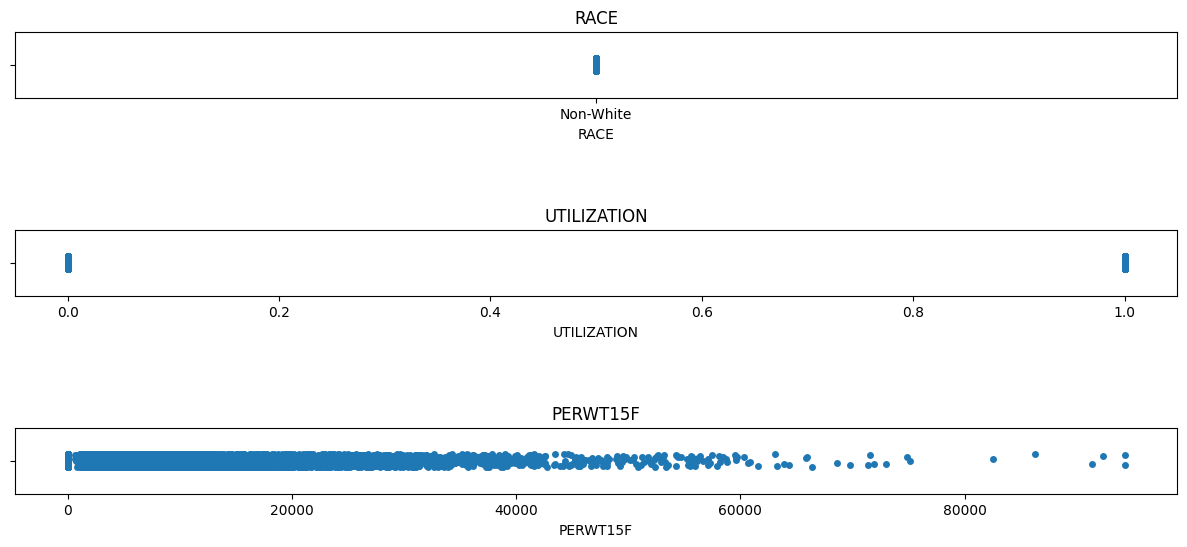

In [29]:
visualize_cols_distributions(df_panel_19_reduced[list(failed_col_mappers_19)])


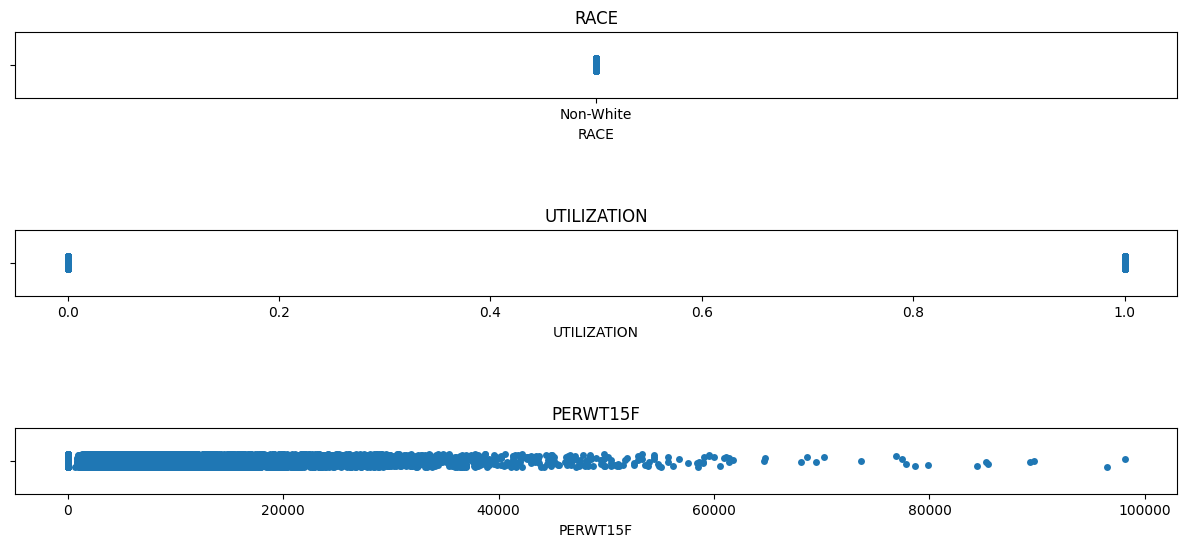

In [30]:
visualize_cols_distributions(df_panel_20_reduced[list(failed_col_mappers_20)])


In [31]:
# ##### It looks like Race and Utilization seem to follow an enumerated schema, but PERWT15F doesn't and it is worth investigating more


In [32]:
def scatter_boxplot_overlay(data, x_col):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
    plt.subplots_adjust(hspace=1)
    
    axes[0].set_title(x_col)
    sns.histplot(data[x_col], kde=False, ax=axes[0], color='blue', bins=300, alpha=0.7)
        
    axes[1].set_title(f'{x_col} (log transformed)')
    log_data= np.log(data[x_col] + 1)
    sns.histplot(log_data ,ax=axes[1], kde=False, color='red', bins=300, alpha=0.7)
    
    # compute standard deviation ranges
    log_std = np.std(log_data)
    log_mean = np.mean(log_data)

    # we know that 99% of the data should lie within 3 stddevs
    for i in range(3):
        left, right = log_mean - ((i+1) * log_std), log_mean + ((i+1) * log_std) 
        axes[1].fill_betweenx(
                        [0, 600], 
                        left, right, color='green', alpha=0.3
                    )
        
        # we only care about right side of data outliers
        num_outliers = (log_data > right).sum()
        print(f'Number of data points outside right {i+1} stddev bound: {num_outliers}')
        
    plt.show()

Number of data points outside right 1 stddev bound: 312
Number of data points outside right 2 stddev bound: 0
Number of data points outside right 3 stddev bound: 0


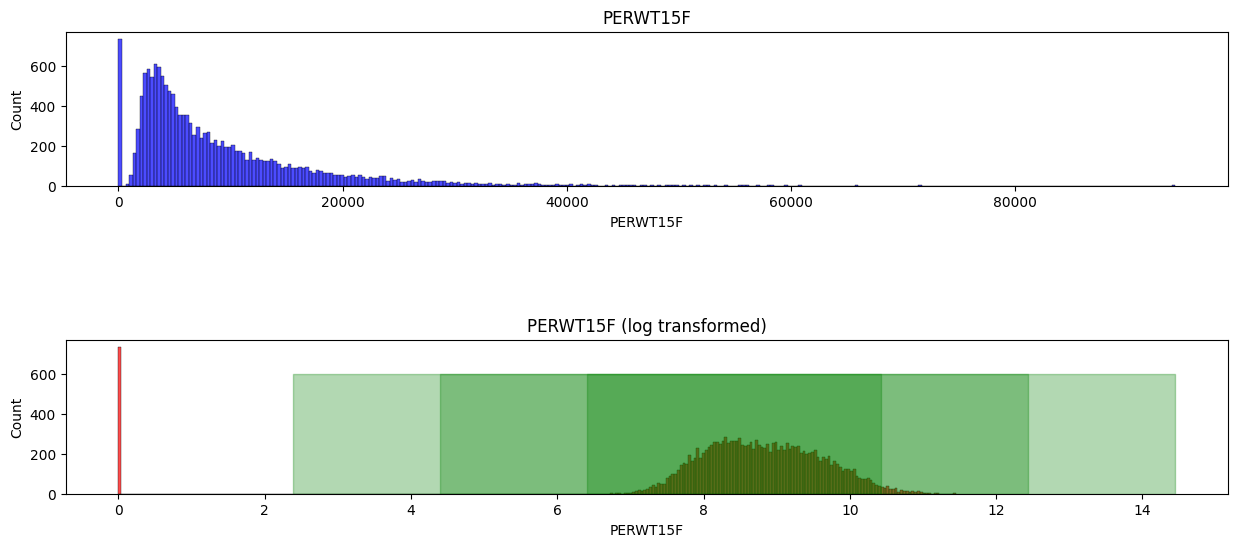

In [33]:
scatter_boxplot_overlay(df_panel_19_reduced, 'PERWT15F')


Number of data points outside right 1 stddev bound: 448
Number of data points outside right 2 stddev bound: 0
Number of data points outside right 3 stddev bound: 0


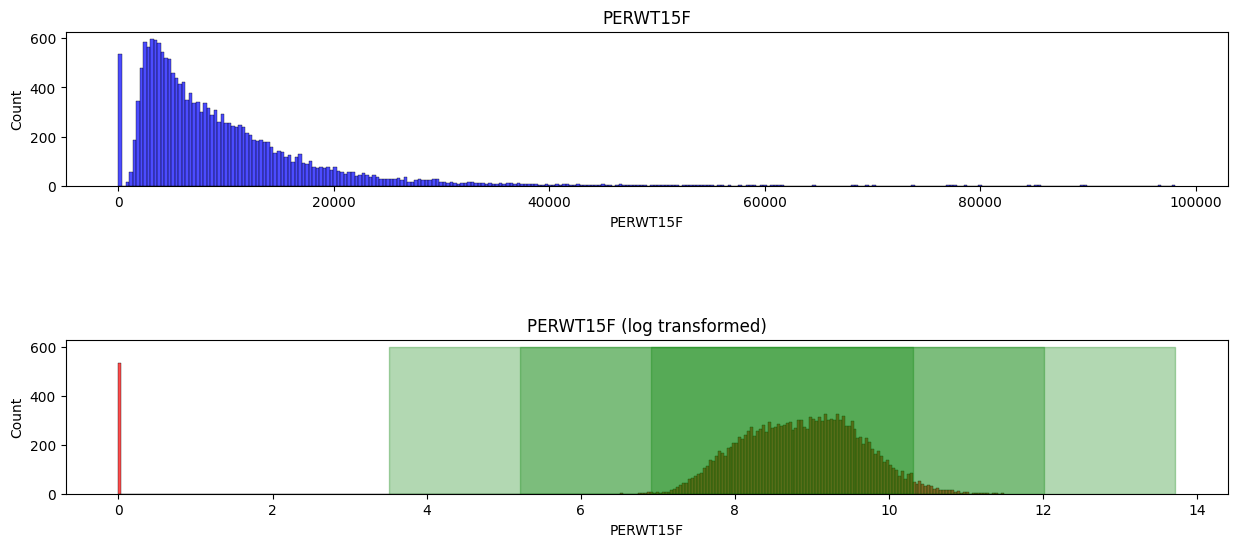

In [34]:
scatter_boxplot_overlay(df_panel_20_reduced, 'PERWT15F')


In [35]:
# ##### It appears that the values found in these additional columns align with our expections and after trying to identify and concerning outliers we have failed. Nice!

# #### Now let's inspect the columns that had values that were failed to map using the codebook

In [36]:
### examine panel 19
for col in unmappable_19_cols:
    print(col, ':', all_mappers_19[col], '\n')


HONRDC : {'-9': 'NOT ASCERTAINED', '-8': 'DK', '-7': 'REFUSED', '-1': 'INAPPLICABLE', '1': 'YES - HONORABLY DISCHARGED', '2': 'NO - NOT HONORABLY DISCHARGED', '3 16': 'OR YOUNGER - INAPPLICABLE', '4': 'NOW ACTIVE DUTY'} 

AGE : {'-1': 'INAPPLICABLE', '0 - 4': 'AGE', '5 - 17': 'AGE', '18 - 24': 'AGE', '25 - 44': 'AGE', '45 - 64': 'AGE', '65 - 85': 'AGE'} 

MCS42 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '0.05 - 75.51': ''} 

K6SUM42 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '0 - 24': 'RATING OF LAST 30 DAYS'} 

PHQ242 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '0 - 6': 'RATING OF LAST 2 WEEKS'} 

PCS42 : {'-9': 'NOT ASCERTAINED', '-1': 'INAPPLICABLE', '4.41 - 72.07': ''} 



In [37]:
df_panel_19_reduced[list(unmappable_19_cols)].describe()


,HONRDC,AGE,MCS42,K6SUM42,PHQ242,PCS42
count,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000
mean,2.224889,35.090461,30.851517,1.274289,-0.003853,29.358455
std,0.512242,22.475549,26.968146,3.955331,1.278136,25.996522
min,1.000000,0.000000,-9.000000,-9.000000,-1.000000,-9.000000
25%,2.000000,15.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,2.000000,33.000000,42.480000,0.000000,0.000000,39.505000
75%,3.000000,53.000000,56.580000,2.000000,0.000000,54.800000
max,4.000000,85.000000,75.510000,24.000000,6.000000,72.070000


In [38]:
def visualize_cols_distributions_with_mapper(df, mapper):
    num_columns = len(df.columns)
    
    figsize = (15, num_columns * 2)
    # Create a figure with a specified number of subplots
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=figsize)

    if num_columns == 1:
        axes = [axes]
    
    for i, col in enumerate(df.columns):
        axes[i].set_title(col)
        
        sns.stripplot(x=df[col], ax=axes[i], orient='h', jitter=True)
        
        vlines = []
        for key, value in mapper[col].items():
            matches = re.findall(r"-?\d+(?:\.\d+)?", key)
            vlines.append([float(match) if '.' in match else int(match) for match in matches])

        for line in vlines:
            if len(line) == 1:
                axes[i].axvline(x=line[0], color='g', linestyle='--')
            elif len(line) == 2:
                axes[i].fill_betweenx(
                    [-1, 1], 
                    line[0], line[1], color='green', alpha=0.3
                )
    
    plt.subplots_adjust(hspace=2)
    
    plt.show()

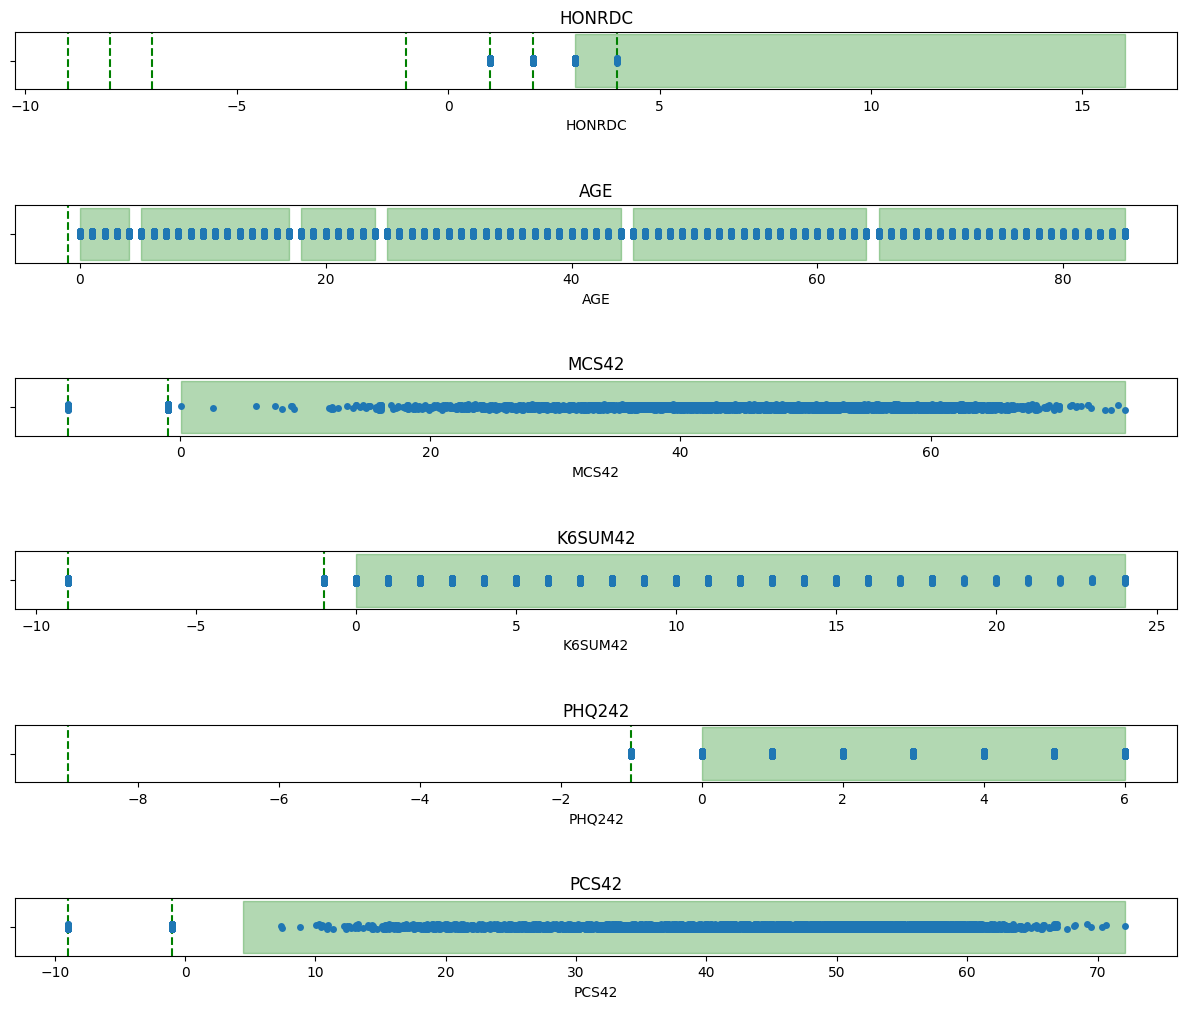

In [39]:
visualize_cols_distributions_with_mapper(df_panel_19_reduced[list(unmappable_19_cols)], all_mappers_19)


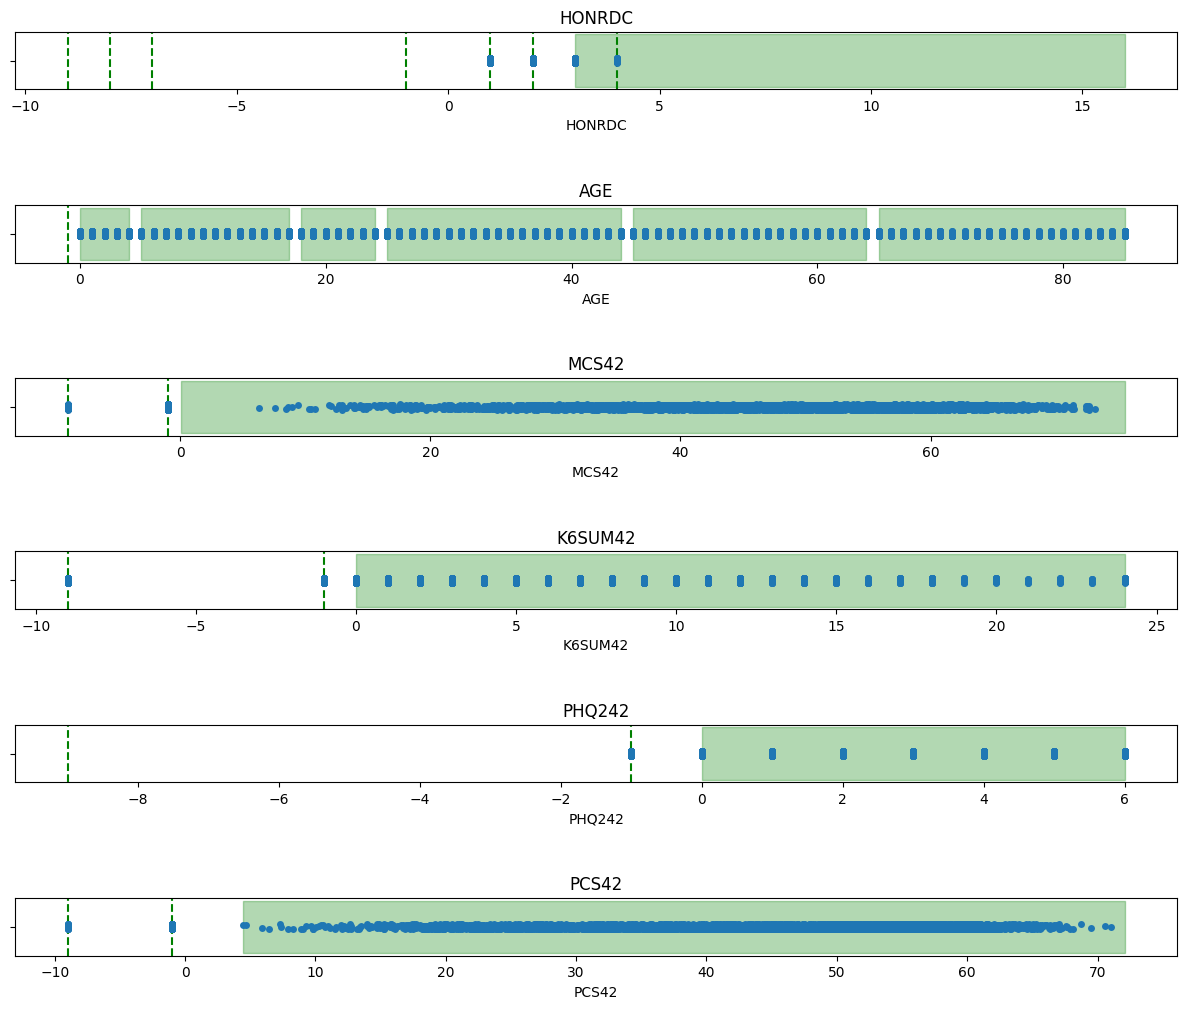

In [40]:
visualize_cols_distributions_with_mapper(df_panel_20_reduced[list(unmappable_20_cols)], all_mappers_20)


In [41]:
# ##### It looks like the reason why these colums couldn't get mapped was because they included numerical ranges of values but all of the values we are seeing lie within the ranges/values defined in the codemapper


#### 2.4 Correlation Analysis

In [42]:
regions = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}
sex = {1: 'MALE', 2:'FEMALE'}
marry = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'MARRIED', 2: 'WIDOWED', 3: 'DIVORCED', 4: 'SEPARATED', 5: 'NEVER MARRIED', 6: 'UNDER 16 - INAPPLICABLE', 7: 'MARRIED IN ROUND', 8: 'WIDOWED IN ROUND', 9: 'DIVORCED IN ROUND', 10: 'SEPARATED IN ROUND'}
ftstu = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE', 1: 'FULL-TIME', 2: 'PART-TIME', 3: 'NOT A STUDENT'}
actdty = {-9: 'NOT ASCERTAINED', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO', 3: 'UNDER 16 - INAPPLICABLE', 4: 'OVER 59 - INAPPLICABLE'}
honrdc = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO', 3: 'UNDER 16 - INAPPLICABLE', 4: 'ACTIVE DUTY'}
rthlth = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EXCELLENT', 2: 'VERY GOOD', 3: 'GOOD', 4: 'FAIR', 5: 'POOR'}
mnhlth = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EXCELLENT', 2: 'VERY GOOD', 3: 'GOOD', 4: 'FAIR', 5: 'POOR'}
hibpdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
chddx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
angidx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
midx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
ohrtdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
strkdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
emphdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
chbron = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
choldx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
cancerdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
diabdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
jtpain = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
arthdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
arthtype = {-7: 'REFUSED', -1: ' INAPPLICABLE', 1: 'RHEUMATOID ARTHRITIS',2: ' OSTEOARTHRITIS', 3: ' NOT SPECIFIED '}
asthdx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
adhdaddx = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
pregnt = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
wlklim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
actlim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
soclim = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
coglim = {8: 'DK', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
dfhear42 = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
dfsee42 = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
adsmok42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE', 1: 'YES', 2: 'NO'}
pcs42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
mcs42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
k6sum42 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
phq242 = {-9: 'NOT ASCERTAINED', -1: 'INAPPLICABLE'}
empst = {-9: 'NOT ASCERTAINED', -8: 'DK', -7: 'REFUSED', -1: 'INAPPLICABLE', 1: 'EMPLOYED AT RD INT DATE', 2: 'JOB TO RETURN TO AT RD INT DATE', 3: ' JOB DURING RD REF PERIOD', 4: 'NOT EMPLOYED DURING RD'}
povcat = {1: 'POOR/NEGATIVE', 2: 'NEAR POOR', 3: 'LOW INCOME', 4: 'MIDDLE INCOME', 5: 'HIGH INCOME'}
inscov = {1: 'ANY PRIVATE', 2: 'PUBLIC ONLY', 3: 'UNINSURED'}

valueMappings = {'REGION': regions, 'SEX': sex, 'MARRY': marry, 'FTSTU': ftstu, 'ACTDTY': actdty, 'HONRDC': honrdc,
       'RTHLTH': rthlth, 'MNHLTH': mnhlth, 'HIBPDX': hibpdx, 'CHDDX': chddx, 'ANGIDX': angidx, 'MIDX': midx, 'OHRTDX': ohrtdx,
       'STRKDX': strkdx, 'EMPHDX': emphdx, 'CHBRON': chbron, 'CHOLDX': choldx, 'CANCERDX': cancerdx, 'DIABDX': diabdx, 'JTPAIN': jtpain,
       'ARTHDX': arthdx, 'ARTHTYPE': arthdx, 'ASTHDX': asthdx, 'ADHDADDX': adhdaddx, 'PREGNT': pregnt, 'WLKLIM': wlklim,
       'ACTLIM': actlim, 'SOCLIM': soclim, 'COGLIM': coglim, 'DFHEAR42': dfhear42, 'DFSEE42': dfsee42, 'ADSMOK42': adsmok42,
       'PCS42': pcs42, 'MCS42': mcs42, 'K6SUM42': k6sum42, 'PHQ242': phq242, 'EMPST': empst, 'POVCAT': povcat, 'INSCOV': inscov}

In [43]:
for variable in valueMappings:
    df_panel_19_reduced[variable] = df_panel_19_reduced[variable].replace(valueMappings[variable])
    df_panel_20_reduced[variable] = df_panel_20_reduced[variable].replace(valueMappings[variable])

/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/2586674155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_19_reduced[variable] = df_panel_19_reduced[variable].replace(valueMappings[variable])
/var/folders/jz/9_xh9kgd079c6v8py7vvz7hr0000gn/T/ipykernel_45732/2586674155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_20_reduced[variable] = df_panel_20_reduced[variable].replace(valueMappings[variable])


In [44]:
df_panel_19_reduced.columns

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F'],
      dtype='object')

<Axes: >

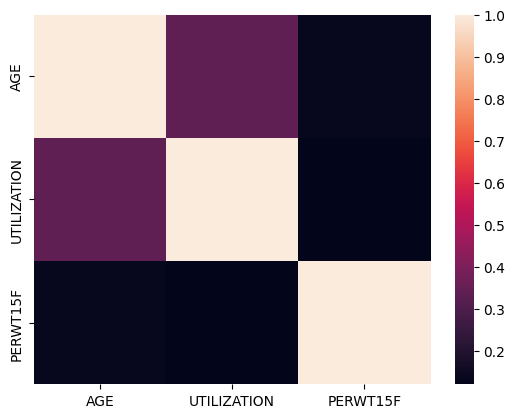

In [45]:
# Preliminary data visualizations
# Correlation plots
numerCol = df_panel_19_reduced.select_dtypes("number")
corr= numerCol.corr()
sns.heatmap(corr)



<Axes: >

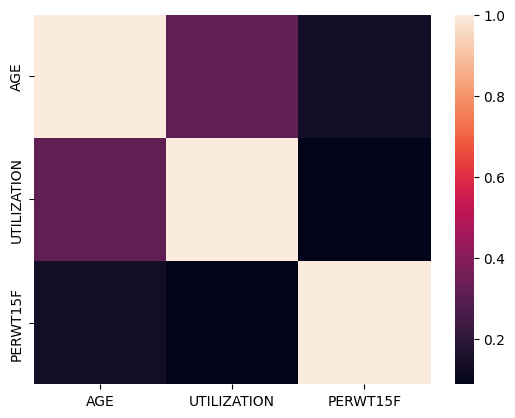

In [46]:
numerCol = df_panel_20_reduced.select_dtypes("number")
corr= numerCol.corr()
sns.heatmap(corr)

In [47]:
import scipy.stats as stats

# Create a contingency table
contingency_table = pd.crosstab(df_panel_19_reduced['RACE'], df_panel_19_reduced['UTILIZATION'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Contingency Table:
UTILIZATION      0     1
RACE                    
Non-White    13112  2718

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[13112.  2718.]]


In [48]:
# Create a contingency table
contingency_table = pd.crosstab(df_panel_20_reduced['RACE'], df_panel_20_reduced['UTILIZATION'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)

Contingency Table:
UTILIZATION      0     1
RACE                    
Non-White    14546  3024

Chi-Square Statistic: 0.0
p-value: 1.0
Degrees of Freedom: 0
Expected Frequencies:
[[14546.  3024.]]


#### 2.5 Other analysis

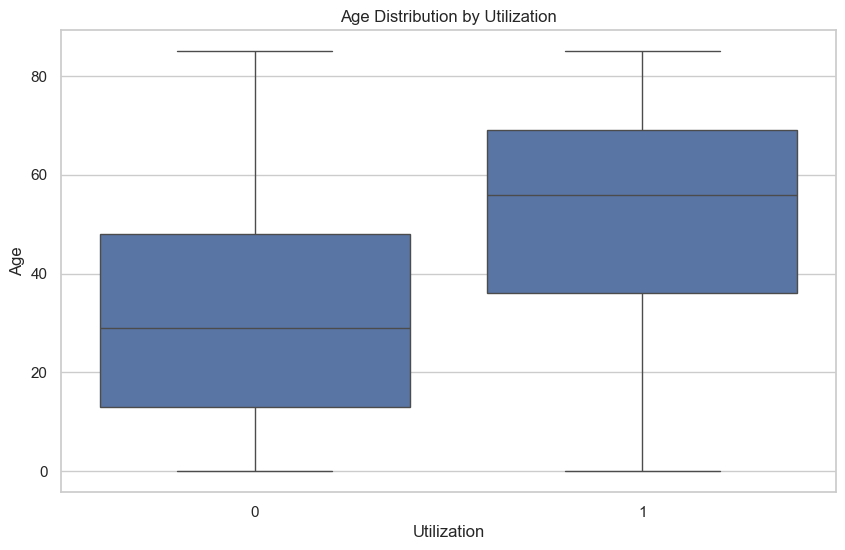

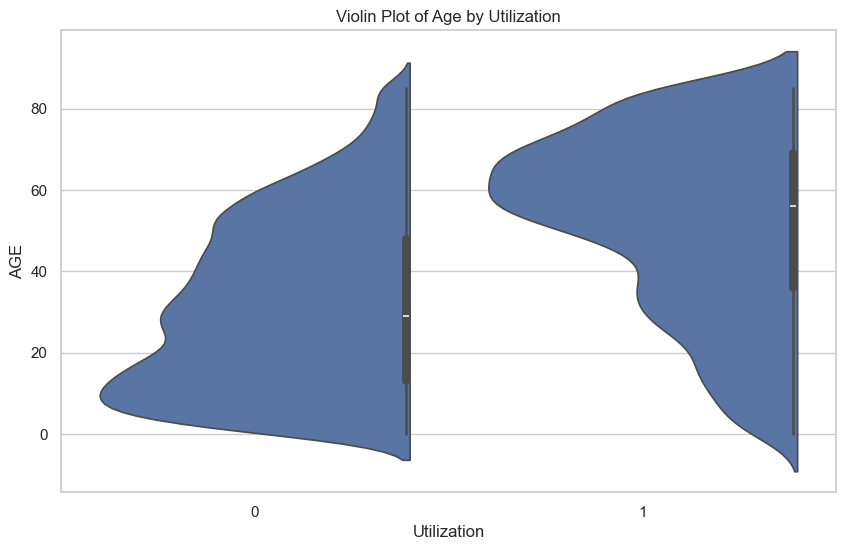

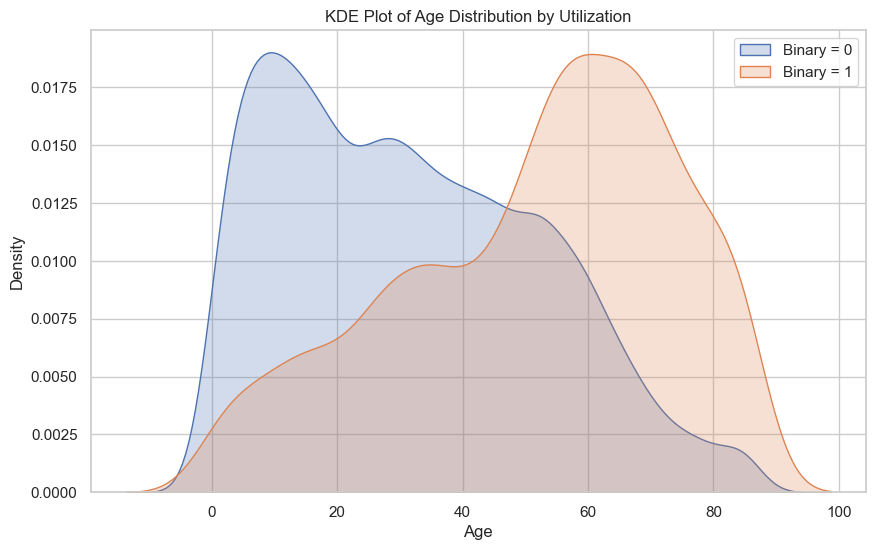

In [49]:
sns.set_theme(style="whitegrid")

# 1. Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced)
plt.title('Age Distribution by Utilization')
plt.xlabel('Utilization')
plt.ylabel('Age')
plt.show()

# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced, split=True)
plt.title('Violin Plot of Age by Utilization')
plt.xlabel('Utilization')
plt.ylabel('AGE')
plt.show()

# 3. Overlaid KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_panel_19_reduced[df_panel_19_reduced['UTILIZATION'] == 0]['AGE'], label='Binary = 0', fill=True)
sns.kdeplot(df_panel_19_reduced[df_panel_19_reduced['UTILIZATION'] == 1]['AGE'], label='Binary = 1', fill=True)
plt.title('KDE Plot of Age Distribution by Utilization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

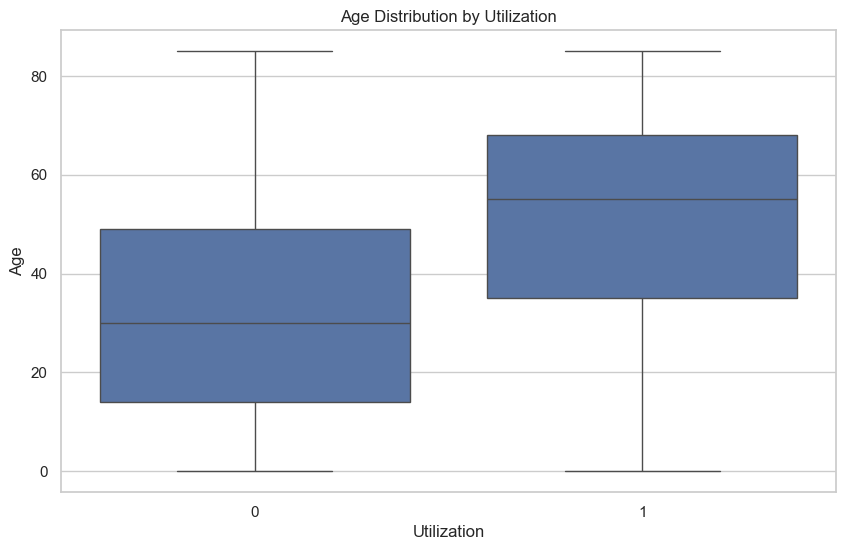

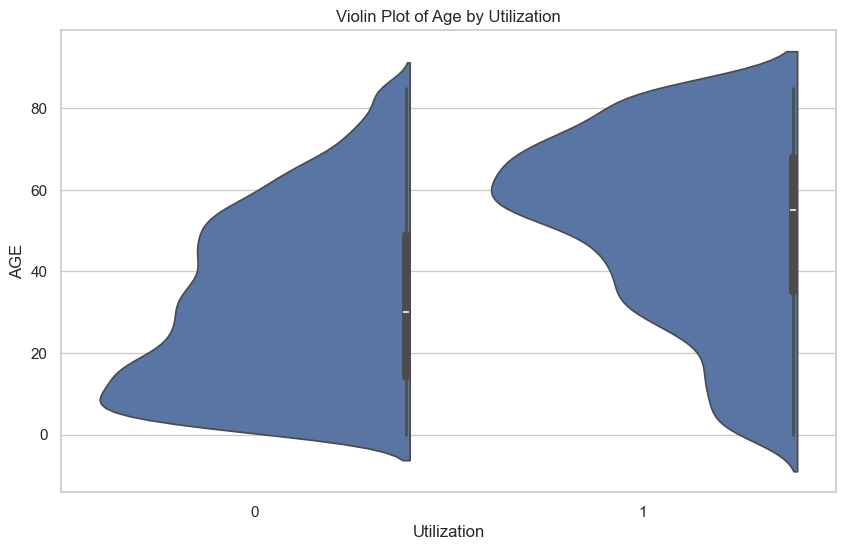

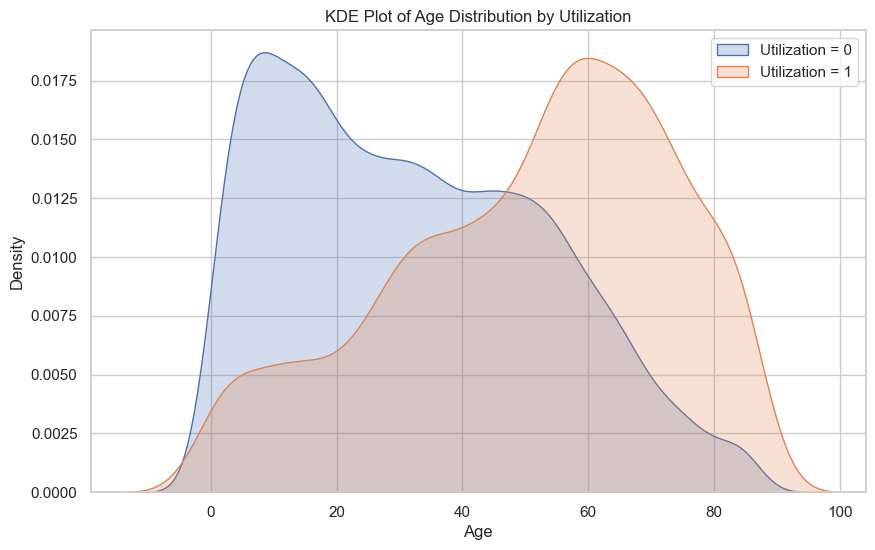

In [50]:
# 1. Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_20_reduced)
plt.title('Age Distribution by Utilization')
plt.xlabel('Utilization')
plt.ylabel('Age')
plt.show()

# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='UTILIZATION', y='AGE', data=df_panel_20_reduced, split=True)
plt.title('Violin Plot of Age by Utilization')
plt.xlabel('Utilization')
plt.ylabel('AGE')
plt.show()

# 3. Overlaid KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_panel_20_reduced[df_panel_20_reduced['UTILIZATION'] == 0]['AGE'], label='Utilization = 0', fill=True)
sns.kdeplot(df_panel_20_reduced[df_panel_20_reduced['UTILIZATION'] == 1]['AGE'], label='Utilization = 1', fill=True)
plt.title('KDE Plot of Age Distribution by Utilization')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

-----
End of Exploratory Data Analysis

_Items below will be updated as course progress_

### [3.](#Table-of-Contents) Model Development 

### [4.](#Table-of-Contents) Model Evaluation

### [5.](#Table-of-Contents) Bias Mitigation

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion